In [1]:
#environment setup

!pip install matplotlib pandas numpy scipy seaborn mne
!pip install requests wget
!pip install h5py tables
!pip install wfdb pyEDFlib
!pip install joblib

In [2]:
# imports 

import os
import os.path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import mne
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold, KFold, cross_validate, GridSearchCV
from sklearn.base import clone
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
def read_files(directory_path):
    #read all files in the folder
    file_list = os.listdir(directory_path)
    file_list = [os.path.join(directory_path, file_name) for file_name in file_list]
   
    #sort alphabetically
    file_list.sort()
        
    return file_list

In [4]:
DOWNLOAD_DIR = r"Epileptologie"
#healthy set A = folder Z
#healthy set B = folder O
#set C = folder N
#set D = folder F
#set E = folder S

# get folder lists
EPIL_dir_file_list = read_files(DOWNLOAD_DIR)

inter_ictal_file = os.path.join(EPIL_dir_file_list[0], 'F060.txt')
ictal_file = os.path.join(EPIL_dir_file_list[3], 'S017.txt')

In [5]:
def load_pandas(file, info=False):
    
    data = pd.read_csv(file,       
                      header=None,     
                      dtype=float)
    
    if info:
        # print detailed information on the data
        print('\nData Information')
        data.info()
        
        # print first 5 rows and columns
        print('\nDataframe Head')
        display(data.head())
        
    return data

inter_i_df = load_pandas(inter_ictal_file, info=False)
ictal_df = load_pandas(ictal_file, info=False)

In [6]:
def create_mne_object(data, info):
    data = data.apply(lambda x: x*1e-6)
    # transpose the data
    data_T = data.transpose()
    # create raw mne object
    raw = mne.io.RawArray(data_T, info)
    
    return raw

Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Using matplotlib as 2D backend.


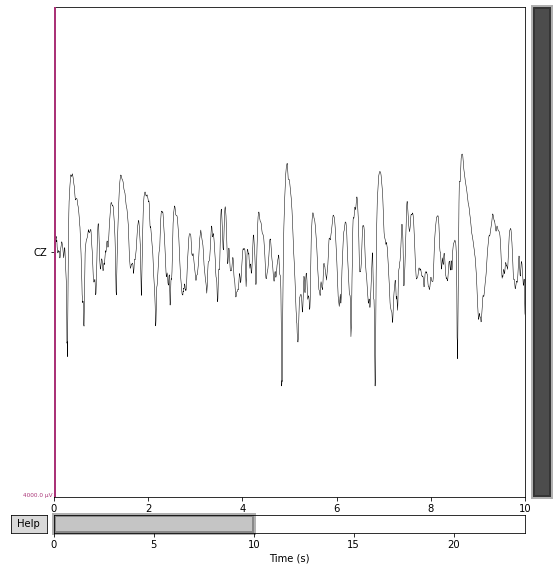

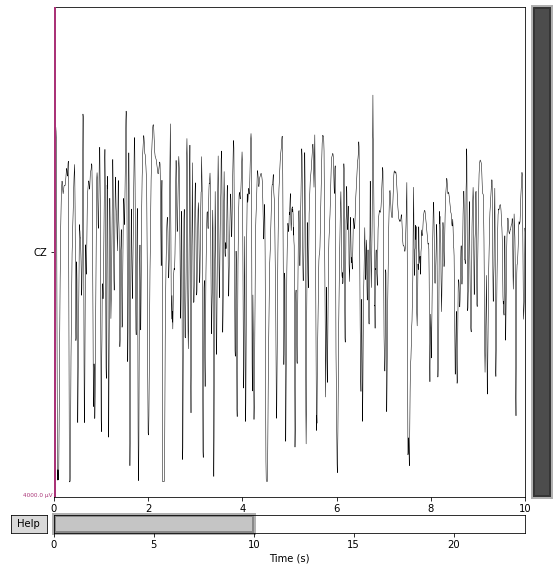

In [7]:
sample_rate = 173.61

# create an mne info file with meta data about the EEG
info_file = mne.create_info(ch_names=['CZ'], sfreq=sample_rate, 
                       ch_types=['eeg'])

inter_ictal_mne = create_mne_object(inter_i_df, info_file)
ictal_mne = create_mne_object(ictal_df, info_file)

inter_ictal_mne.plot(scalings=dict(eeg=20e-4)).savefig("inter_ictal.png")
ictal_mne.plot(scalings=dict(eeg=20e-4)).savefig("ictal.png")

In [8]:
# calculate Welch's periodogram
# get the mean for all frequencies in the band
def mean_bandpower(raw_object, f_band):
    band = np.asarray(f_band)
    low, high = band

    # calculate welch
    psds, freqs = mne.time_frequency.psd_welch(raw_object, fmin=low, fmax=high)
    # transpose
    psds = psds.T
    
    #put into a dataframe
    psds = pd.DataFrame(psds, index=freqs)
    
    # get min max indexes of the band
    psds = psds.iloc[[0, -1]]
    
    # get the mean power for the band
    psds = psds.mean()
    
    return psds

In [9]:
def concat_features(features, data, axis=1):
    
    # if the feature set is empty
    if features.size == 0:
        features = data
    else:
        features = np.concatenate((features, data), axis)
    
    return features

In [10]:
# calculate mean power for each band
def powers(raw_object):
    bands = [[1,4],[4,8],[8,12], [12,30],[30,70]]
    
    welch = pd.DataFrame()
    feature_names = []
    for band in bands:
        band_power = mean_bandpower(raw_object, band)
        welch = concat_features(welch, band_power, axis=0)
        
        # append the channel name and respective band to the list
        # e.g. CZ(1 - 4Hz)
        feature_names.append('CZ'+'('+str(band[0])+' - '+str(band[1])+'Hz' + ')')
    
    return welch, feature_names 

In [11]:
def create_feature_table(features, file):
    # get the file name from the file (e.g. F001)
    # add it to features table 
    file_name = re.findall('\w\d+', file)[0]
    features['file'] = file_name
    
    # assign classes
    if re.findall('S', file_name):
        features['class'] = 'seizure'
    else:
        features['class'] = 'non-seizure'
        
    # make respective location columns
    # depending on the  file's origin directory
    if re.findall('Z|O', file_name):
        features['eeg'] = 'scalp'
    elif re.findall('N', file_name):
        features['eeg'] = 'ieeg hippocampus'
    # if the file identifier has an S or F in...
    elif re.findall('F|S', file_name):
        # make a location column with 'intracranial epileptogenic zone' in
        features['eeg'] = 'ieeg zone'
        
    # name the index
    features.index.name = 'powers'
    
    # add the file and class to the index
    features = features.set_index(['file', 'class', 'eeg'], drop=False)
    # reorder the index 
    features = features.reorder_levels(['class', 'eeg', 'file'], axis='index')
        
    return features

In [12]:
# helper function
# receive a dataframe (file), conver it into raw
# compute welch for the given object

def transform(df, features):
    # create raw
    raw = create_mne_object(df, info_file)
    # cmpute welch
    welch, feature_names = powers(raw)
    # append the data into feature set
    features = concat_features(features, welch)
    return features, feature_names

In [13]:
# create the dataframe/table of powers for all the files

def all_features():
    feature_df = pd.DataFrame()
    features = np.array([])
    # iterate across the list of folders
    for folder in EPIL_dir_file_list:
        # get a list of files in each folder
        folder_files_list = read_files(folder)
        # for each file:
        # 1. load it into df
        # 2. compute powers
        # 3. put the numpy output back into a df with freq band as index name
        # 4. transpose
        # 5. create the large table with class, eeg type, file name, etc.
        # 6. concat the features df
        for file in folder_files_list:
            df = load_pandas(file)
            x_features, feature_names = transform(df, features)
            # put the numpy output back into a pandas df and transpose
            x_features = pd.DataFrame(x_features, index=feature_names)
            x_features = x_features.T
            x_features = create_feature_table(x_features, file)
            
            if feature_df.empty:
                feature_df = x_features
            else:
            # concat the two down the index
                feature_df = pd.concat([feature_df, x_features], axis='index')
        
    return feature_df

In [14]:
features = all_features()
display(features)
features.info()

Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.59

Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_chann

Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective 

Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Eff

    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window

Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.59

Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_chann

Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective 

Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Eff

    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window

Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.59

Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_chann

Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective 

Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Eff

    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window

Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.59

Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_chann

Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective window size : 1.475 (s)
Effective 

CZ(1 - 4Hz)   CZ(4 - 8Hz)  CZ(8 - 12Hz)  \
class       eeg       file                                             
non-seizure ieeg zone F001  1.447977e-10  4.327079e-11  9.533954e-12   
                      F002  2.327514e-09  3.173528e-10  1.323027e-10   
                      F003  1.336212e-09  1.511889e-10  1.942877e-10   
                      F004  3.136504e-10  1.337888e-10  2.533709e-11   
                      F005  1.070073e-09  4.570827e-10  2.344989e-10   
...                                  ...           ...           ...   
            scalp     Z096  1.589390e-10  6.478049e-11  7.843165e-11   
                      Z097  1.332872e-10  6.208324e-11  1.035168e-10   
                      Z098  1.729393e-10  4.799837e-11  9.362672e-11   
                      Z099  1.247444e-10  1.020368e-10  1.212154e-10   
                      Z100  1.936722e-10  5.571544e-11  1.047468e-10   

                            CZ(12 - 30Hz)  CZ(30 - 70Hz)  file        class  \
class       eeg       file                                                    
non-seizure ieeg zone F001   3.992319e-12   2.341886e-13  F001  non-seizure   
                      F002   2.607627e-11   2.752197e-13  F002  non-seizure   
                      F003   4.134837e-11   6.579971e-13  F003  non-seizure   
                      F004   5.375919e-12   1.818696e-13  F004  non-seizure   
                      F005   4.887948e-11   2.885021e-12  F005  non-seizure   
...                                   ...            ...   ...          ...   
            scalp     Z096   4.388750e-11   1.751404e-12  Z096  non-seizure   
                      Z097   3.563999e-11   1.091107e-12  Z097  non-seizure   
                      Z098   1.007314e-10   1.562400e-12  Z098  non-seizure   
                      Z099   7.172184e-11   3.843599e-12  Z099  non-seizure   
                      Z100   8.339872e-11   1.385586e-12  Z100  non-seizure   

                                  eeg  
class       eeg       file             
non-seizure ieeg zone F001  ieeg zone  
                      F002  ieeg zone  
                      F003  ieeg zone  
                      F004  ieeg zone  
                      F005  ieeg zone  
...                               ...  
            scalp     Z096      scalp  
                      Z097      scalp  
                      Z098      scalp  
                      Z099      scalp  
                      Z100      scalp  

[500 rows x 8 columns]

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 500 entries, ('non-seizure', 'ieeg zone', 'F001') to ('non-seizure', 'scalp', 'Z100')
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CZ(1 - 4Hz)    500 non-null    float64
 1   CZ(4 - 8Hz)    500 non-null    float64
 2   CZ(8 - 12Hz)   500 non-null    float64
 3   CZ(12 - 30Hz)  500 non-null    float64
 4   CZ(30 - 70Hz)  500 non-null    float64
 5   file           500 non-null    object 
 6   class          500 non-null    object 
 7   eeg            500 non-null    object 
dtypes: float64(5), object(3)
memory usage: 53.7+ KB


In [15]:
classes = features['class']
le = LabelEncoder()

# select only intracranial EEG
r_features = features[features.eeg != 'scalp']
# select features only
r_features_drop = r_features.drop(['class', 'file', 'eeg'], axis='columns')

# create inputs
data_x = r_features_drop.values

# fit le and return encoded labels
data_y = le.fit_transform(r_features['class'])

data_y[:5]

array([0, 0, 0, 0, 0])

In [30]:
TEST_SIZE = 0.1
RANDOM_STATE = 0

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

# SVM
svc = Pipeline([('scl', StandardScaler()),
                    ('clf', SVC(kernel='rbf', 
                                class_weight = 'balanced',
                                probability=True,
                                random_state=RANDOM_STATE))])

# create 
k_fold = RepeatedKFold(n_splits = 10,
                         n_repeats = 10)

scoring = {'accuracy' : make_scorer(accuracy_score),
           'precision' : make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1_score' : make_scorer(f1_score)}

In [31]:
params = {'clf__C': [0.5, 1.0, 2.0, 4.0, 8.0, 10.0, 100.0], 
              'clf__gamma': [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9]}

def perform_grid_search(X_train, y_train, estimator, cv, 
                param_grid, scorer):
    
    # create gridsearch
    clf = GridSearchCV(estimator=estimator,        #svm
                    param_grid=params,            
                    scoring=scoring['accuracy'],   
                    cv=cv,                         #k folds
                    return_train_score=True,
                    refit = True,
                    n_jobs=-1)
    
    # fit the gs classifier
    clf = clf.fit(X_train, y_train)
    
    # get the best svm
    clf_pipe = clf.best_estimator_
    
    return clf_pipe

svm_pipe = perform_grid_search(X_train, y_train, svc, k_fold, params, scoring)

In [32]:
results = cross_validate(estimator=svm_pipe, 
                         X=data_x, 
                         y=data_y, 
                         scoring = scoring,
                         cv=k_fold,
                         n_jobs=-1)

print('Classifier accuracy: %.3f +/- %.3f' % (np.mean(results['test_accuracy']), np.std(results['test_accuracy'])))
print('Classifier error rate: %.3f +/- %.3f' % ((1 - np.mean(results['test_accuracy'])), np.std(results['test_accuracy'])))
print('Classifier precision: %.3f +/- %.3f' % (np.mean(results['test_precision']), np.std(results['test_precision'])))
print('Classifier recall: %.3f +/- %.3f' % (np.mean(results['test_recall']), np.std(results['test_recall'])))
print('Classifier f1-score: %.3f +/- %.3f' % (np.mean(results['test_f1_score']), np.std(results['test_f1_score'])))

Classifier accuracy: 0.974 +/- 0.027
Classifier error rate: 0.026 +/- 0.027
Classifier precision: 0.954 +/- 0.062
Classifier recall: 0.970 +/- 0.054
Classifier f1-score: 0.960 +/- 0.043


In [33]:
def evaluate_model():
    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x):
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]

        # Fit the classifier
        classifier = svm_pipe.fit(train_x, train_y)

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets

In [34]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)

    cm_display = ConfusionMatrixDisplay(cm).plot()
    np.set_printoptions(precision=2)
    
    plt.savefig("confmat.png")
    return cm

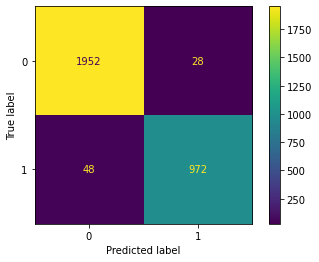

In [35]:
predicted_target, actual_target = evaluate_model()
matrix = plot_confusion_matrix(predicted_target, actual_target)

In [36]:
FP = matrix[0,1]
TN = matrix[0,0]
TP = matrix[1,1]
FN = matrix[1,0]
print(FP)
print(TN)
print(TP)
print(FN)

ERR = (FP+FN)/(FP+FN+TP+TN)
ACC = 1-ERR
TPR = TP/(FN+TP)
TNR = TN / (TN + FP)
FPR = FP/(FP+TN)
PRE = TP/(TP+FP)
REC = TP/(FN+TP)
F1 = 2*((PRE*REC)/(PRE+REC))

print('True positive rate (TPR): %.3f' % TPR)     # recall, or sensitivity
print('True negative rate (TNR): %.3f' % TNR)     # specificity
print('False positive rate (FPR): %.3f' % FPR)
print('Error (ERR): %.3f' % ERR)
print()
print('Accuracy (ACC): %.3f' % ACC)
print('Precision (PRE): %.3f' % PRE)
print('Recall (REC): %.3f' % REC)
print('F1-score (F1): %.3f' % F1)

28
1952
972
48
True positive rate (TPR): 0.953
True negative rate (TNR): 0.986
False positive rate (FPR): 0.014
Error (ERR): 0.025

Accuracy (ACC): 0.975
Precision (PRE): 0.972
Recall (REC): 0.953
F1-score (F1): 0.962


In [37]:
# import joblib
from joblib import dump

# dump the pipeline model
dump(svm_pipe, filename="svm.joblib")

['svm.joblib']